In [1]:
# Torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.optim as optim
from torcheval.metrics import *

# Benny pointnet
from pointnet2_benny import pointnet2_cls_msg
from pointnet2_benny import provider

# Other
from tqdm import tqdm
import nibabel
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score
from collections import Counter
import random

# Custom modules
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.SubjectDataset import *

### Hyperparameters

In [2]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-3T-processed"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the data of interest
data_string = 'hcampus_pointcloud'

# Dictionary key representing the disease labels
labels_string = 'research_group'

downsample_majority=False

batch_size = 20

test_size = 0.2

num_epochs = 15

learning_rate = 0.0001

threshold = 0.5

### Dataset creation

In [3]:
dataset = SubjectDataset(data_path, selected_labels, downsample_majority=downsample_majority)

### Data checks

In [4]:
print(f"Dataset size: {len(dataset)}\n")

labels = []

for subject in range(len(dataset.subject_list)):
    
    group = dataset.__getitem__(subject)['research_group']
    
    labels.append(group)
    
print(f"Unique labels: {np.unique(labels)}\n")

print("Labels count: ")
print(Counter(labels))


Dataset size: 386

Unique labels: [0 1]

Labels count: 
Counter({1: 226, 0: 160})


### Loader config

In [5]:

train_data, test_data = split_dataset(dataset, test_size=test_size)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn([data_string, labels_string]))

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn([data_string, labels_string]))



### Cuda setup

In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [7]:
from torcheval.metrics import *

num_classes = dataset.num_classes

training_losses, validation_losses = [], []

conf_matices = []

accuracies = []

precisions = []

recalls = []

model = pointnet2_cls_msg.get_model(num_classes, normal_channel=False)

criterion = pointnet2_cls_msg.get_loss()

# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

model.to(device)

for epoch in range(num_epochs):
    
    print(f"Starting epoch {epoch + 1}\n")
    
    # Training loop
    model.train()
    
    running_loss = 0.0

    for batch_idx, dict in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        # Access dict returned by dataset __getitem__
        points = dict[data_string]
        labels = dict[labels_string]
        
        # Benny script augmentation
        '''
        points = points.numpy()
        points = provider.random_point_dropout(points)
        points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)'''
        
        # Transpose as in benny script (NB why does it need a transpose)
        points = points.transpose(2, 1)
        
        points, labels = points.to(device), labels.to(device)

        # Forward pass
        output, _ = model(points)

        # Calculate loss, trans_feat argument as None as not used in this function
        loss = criterion(output, labels, None)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Multiply loss by batch size to account for differences in batch size (e.g last batch)
        running_loss += loss.item() * points.size(0)
        
    training_losses.append(running_loss/len(train_dataloader))
    
    # Validation loop
    model.eval()
    
    running_loss = 0.0
        
    conf_matrix = BinaryConfusionMatrix()
    
    accuracy = BinaryAccuracy()

    precision = BinaryPrecision()
    
    recall = BinaryRecall()
    
    
    with torch.no_grad():
        
        for batch_idx, dict in enumerate(test_dataloader):
            
            points = dict[data_string]
            labels = dict[labels_string]
            
            points = points.transpose(2, 1)
            
            points, labels = points.to(device), labels.to(device)
            
            output, _ = model(points)
            
            running_loss += criterion(output, labels, None).item() * points.size(0)
            
            # Apply exponent as the output of the model is log softmax
            pred_probability = torch.exp(output)
            
            # Threshold is variable to give preference to FN or FP
            pred_labels = (pred_probability[:, 1] >= threshold).int()
            
            # Old label conversion
            # pred_labels = torch.argmax(pred_probability, dim=-1)

            # Update metrics
            conf_matrix.update(pred_labels, labels)
            
            accuracy.update(pred_labels, labels)
            
            precision.update(pred_labels, labels)
            
            recall.update(pred_labels, labels)
            
    print(conf_matrix.compute())
    
    accuracies.append(accuracy.compute())
    
    precisions.append(precision.compute())
    
    recalls.append(recall.compute())
                    
    #ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=selected_labels).plot()
    
    validation_losses.append(running_loss/len(test_dataloader))
    
    print(f"\n Epoch {epoch + 1} complete\n")
    print(f"Training loss: {training_losses[-1]}\n")
    print(f"Validation loss: {validation_losses[-1]}\n")
    print(f"Accuracy: {accuracies[-1]}\n")
    print(f"Precision: {precisions[-1]}\n")
    print(f"Recall: {recalls[-1]}\n")
    print("------------------------\n\n\n")

torch.save(model.state_dict(), 'trained_model.pth')
print("Training complete and model saved")

Starting epoch 1



100%|██████████| 16/16 [00:33<00:00,  2.06s/it]


tensor([[ 0., 33.],
        [ 0., 44.]])

 Epoch 1 complete

Training loss: 13.297098230570555

Validation loss: 13.21744953095913

Accuracy: 0.5714285969734192

Precision: 0.5714285969734192

Recall: 1.0

------------------------



Starting epoch 2



100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


tensor([[ 0., 33.],
        [ 0., 44.]])

 Epoch 2 complete

Training loss: 13.863188087940216

Validation loss: 13.355312570929527

Accuracy: 0.5714285969734192

Precision: 0.5714285969734192

Recall: 1.0

------------------------



Starting epoch 3



 44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]


KeyboardInterrupt: 

Notes
- Strange issue where first run (from restart) of the model gives convincing results
- After this, all epochs (even on restart) predict entirely one class and this class swaps over
- Downsampling majority class hasn't fixed this
- Could this be to do with argmax. How should I convert outputs into classes
- Could it be overfitting? Do i need more data

- After 7 epochs, got 65% accuracy with non downsampled majority, learning rate of 0.0001

### Plotting

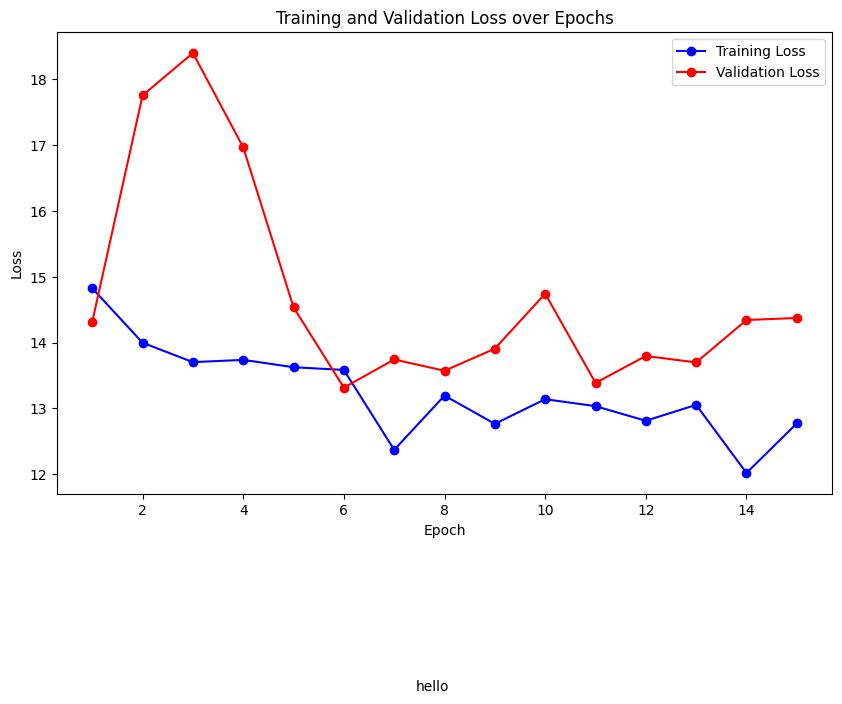

In [29]:
# After training, plot the losses
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue', marker='o')

# Plot validation loss
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='red', marker='o')

# Add labels and title
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figtext(0.5, -0.2, "hello", ha='center', va='top', wrap=True, fontsize=10)


# Display the plot
plt.show()
